## CartPole

In [20]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as tud
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
env = gym.make('CartPole-v0')

### Method 2. DAQN

### Step 1.fill the experience set and train an auto-encoeder

In [3]:
## experience set

class Experience():
    def __init__(self, capacity = 20000):
        self.experience = []  ## store （s,a,r,s'）
        self.capacity = capacity  ## max capacity
        self.volume = 0  ## current capacity
        self.iter = 0
        
    def insert(self, transition):
        if self.volume < self.capacity:
            ## insert directly
            self.experience.append(transition)
            self.volume += 1
        else:
            ## random choose a transition to cover
            self.experience[self.iter] = transition
            self.iter = (self.iter + 1) % self.capacity
    
    def sample(self, batch_size):
        ## random sample a batch including batch_size transitions
        return random.sample(self.experience, k = batch_size)

In [4]:
experience = Experience(capacity = 20000)

while True:
    s0 = env.reset()
    is_end = False
    while not is_end:
        action = env.action_space.sample()
        s1, reward, is_end, _ = env.step(action)
        experience.insert([s0,action,reward,s1])
        s0 = s1
    if experience.volume == experience.capacity:
        break

In [5]:
## Auto Encoder

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, output_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def forward(self, x):
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        return hidden, output

In [6]:
# Dataset and DataLoader

class AEDataset(tud.Dataset):
    def __init__(self, experience):
        state = []
        for s in experience.experience:
            state.append(s[0])
        self.states = torch.Tensor(state)
        
    def __len__(self):
        return len(self.states)
            
    def __getitem__(self, idx):
        return self.states[idx]
    
aedataset = AEDataset(experience)
dataloader = tud.DataLoader(aedataset, batch_size = 64, shuffle = True)

In [7]:
# Pre-train

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoEncoder(4, 16, 3).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for e in range(10):
    losses = []
    for batch in dataloader:
        batch = batch.to(device)
        _, output = model(batch)
        loss = loss_fn(batch, output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    print("epoch:", e, "loss:", round(np.mean(losses),4))

epoch: 0 loss: 0.1225
epoch: 1 loss: 0.0118
epoch: 2 loss: 0.0099
epoch: 3 loss: 0.0098
epoch: 4 loss: 0.0098
epoch: 5 loss: 0.0098
epoch: 6 loss: 0.0097
epoch: 7 loss: 0.0098
epoch: 8 loss: 0.0097
epoch: 9 loss: 0.0097


### Step 2. Use the hidden layer to do DQN

In [8]:
## DQN Approximator

class QNetwork(nn.Module):
    def __init__(self, action_space, model):
        super(QNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(model.input_dim, model.hidden_dim),
            nn.ReLU(),
            nn.Linear(model.hidden_dim, model.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(model.hidden_dim // 2, model.hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(model.hidden_dim // 4, model.output_dim)
        )
        self.encoder.load_state_dict(model.encoder.state_dict())
        self.Network = nn.Linear(model.output_dim, action_space)
        
    def forward(self, x):
        return self.Network(self.encoder(x))

In [16]:
## Agent

class DAQNAgent():
    def __init__(self, env, experience, model, hidden_dim, gamma = 0.9, epsilon = 0.1, decay_rate = 1, learning_rate = 1e-4):
        self.env = env
        self.action_space = env.action_space  
        self.obs_space = env.observation_space.shape[0]
        self.action_len = len([i for i in range(self.action_space.n)])
        self.experience = experience
        self.model = model
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.behaviour_QNetwork = QNetwork(self.action_len, self.model).to(self.device)
        self.target_QNetwork = QNetwork(self.action_len, self.model).to(self.device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.behaviour_QNetwork.parameters(), lr = learning_rate)
        
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.gamma = gamma

    def policy(self, state, epsilon = 0.1):
        if np.random.random() < epsilon:
            action = self.action_space.sample()
        else:
            score = self.behaviour_QNetwork(torch.Tensor(state).to(self.device)).detach()
            action = torch.argmax(score).item()
            
        return action
    
    def learn(self, batch_size, display = False):
        s0 = self.env.reset()
        if display:
            self.env.render()
        is_end = False
        episode_reward = 0
        
        while not is_end:
            ## choose an action and make a step
            a0 = self.policy(s0, epsilon = self.epsilon)
            s1, reward, is_end, _ = self.env.step(a0)
            if display:
                self.env.render()
            if is_end:
                s1 = np.array([100,100,100,100])
            ## store the transition into experience
            self.experience.insert([s0,a0,reward,s1])
            ## sample minibatch from experience
            minibatch = self.experience.sample(batch_size = batch_size)
            s, a, r, s_next = [], [], [], []
            for batch in minibatch:
                s.append(batch[0])
                a.append(batch[1])
                r.append(batch[2])
                s_next.append(batch[3])
            s = torch.Tensor(s).to(self.device)
            a = torch.LongTensor(a).to(self.device).reshape(-1,1)
            r = torch.Tensor(r).to(self.device).reshape(-1,1)
            s_next = torch.Tensor(s_next).to(self.device)
            Q_target = r + self.gamma * torch.max(self.target_QNetwork(s_next),1)[0].reshape(-1,1) * (s_next[:,0] != 100).reshape(-1,1)
            Q_behaviour = self.behaviour_QNetwork(s).gather(1,a)
            loss = self.loss_fn(Q_target, Q_behaviour)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            ## iteration
            s0 = s1
            episode_reward += reward
        
        ## update target network
        self.target_QNetwork.load_state_dict(self.behaviour_QNetwork.state_dict())
        self.epsilon *= self.decay_rate
        
        return episode_reward, loss.item()


In [25]:
## train
daqn_agent = DAQNAgent(env, experience, model, hidden_dim = 16, gamma = 0.99, epsilon = 0.1, decay_rate = 0.9, learning_rate = 1e-3)
MAX_EPISODE = 2000
daqn_episode_reward = []
daqn_loss = []
average_100_step = []

for e in tqdm(range(MAX_EPISODE)):
    reward, loss = daqn_agent.learn(batch_size = 100, display = False)
    daqn_episode_reward.append(reward)
    average_100_step.append(np.mean(daqn_episode_reward[-100:]))
    daqn_loss.append(loss)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [29:31<00:00,  1.13it/s]


Text(0, 0.5, 'reward')

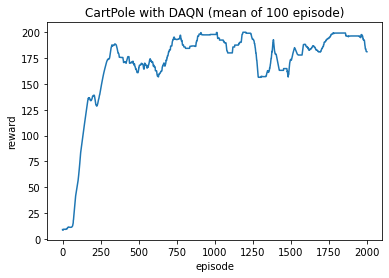

In [26]:
plt.plot(average_100_step)
plt.title("CartPole with DAQN (mean of 100 episode)")
plt.xlabel("episode")
plt.ylabel("reward")